<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE40455-2020](https://jckantor.github.io/CBE40455-2020);
content is available [on Github](https://github.com/jckantor/CBE40455-2020.git).*


<!--NAVIGATION-->
< [3.6 Simulating Queuing Systems](https://jckantor.github.io/CBE40455-2020/03.06-Queuing-Systems-and-Poisson-Processes.html) | [Contents](toc.html) |<p><a href="https://colab.research.google.com/github/jckantor/CBE40455-2020/blob/master/docs/03.07-Application-of-Queuing-Systems.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/CBE40455-2020/03.07-Application-of-Queuing-Systems.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 3.7 Application of Queuing Systems


## 3.7.1 Kendall notation for queues

Kendall notation is a standardized methods to describe and classify queues. The notation consists of three factors written as A/S/c where where A describes the arrival process, S the service process, and c is the number of servers attending the queue.

* $A/S/c$
    * $A$: statistical nature of the arrival process 
    * $S$: Statistical nature of the service process 
    * $c$: Number of servers at the queue node
    
* Typical Statistics
    * D: Deterministic (average arrival rate $\lambda$)
    * M: Markov or memoryless (average arrival rate $r$)
    * G: General or arbitrary distribution (mean $\mu$ and standard deviation $\simga$ or variance $\sigma^2$)
    
Example: M/D/1

![Aircraft queue](https://i0.wp.com/nats.aero/blog/wp-content/uploads/2013/08/aircraft-queue-e1377251576844.jpg?ssl=1)

Example: M/M/8

![Call Center](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Emergency_Call_Center_112.jpg/640px-Emergency_Call_Center_112.jpg)

## 3.7.2 SimPy Stores: A generic tool for simulating queues.

SimPy [shared resources](https://simpy.readthedocs.io/en/latest/topical_guides/resources.html#) provide several means to implement queues in simulations. In particular, the shared resource type [Stores](https://simpy.readthedocs.io/en/latest/topical_guides/resources.html#res-type-store) is easy to use and well-suited to this purpose. The essential features are:

* `store = simpy.Store(env, capacity=4)` creates a new store object with a capacity of 4. Omitting capacity creates an a infinitely long queue.
* `yield store.put(x)` puts a Python object `x` on the queue. If the store is currently full, then generator instance waits until space is available.
* `x = yield store.get()` retrieves a Python object from the store. The default is to recover objects on a first-in-first-out discipline. Other disciplines can be implemented using the `FilterStore` or `PriortyStore` objects.
* `store.items` returns a list of all items currently available in the store. 

## 3.7.3 Example: An Order Processing Queue

A chemical storeroom processes orders for a large research campus. At peak loads it is expected to receive an average of one order every 12 minutes. The time required to process each order is a fixed 10 minutes. 

1. Describe the process using the Kendall notation.

2. Create a simulation of the order queue that operates for 8 hours. Determine the average time between the arrival and completion of an order, and determine the average queue length. 

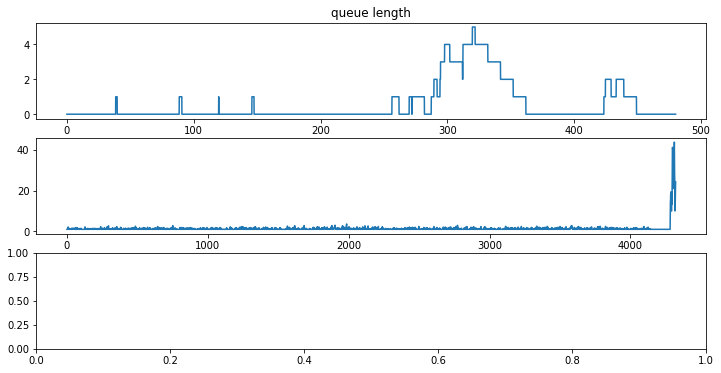

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import simpy
import pandas as pd

# time unit = minutes

order_log = []    # log data on order processing
queue_log = []    # log data on queue length

# log time and queue_length at regular time steps
def queue_logger(t_step=1.0):
    while True:
        queue_log.append([env.now, len(queue.items)])
        yield env.timeout(t_step)

# generate and place orders on the queue at a specified rate
def order_generator(order_rate):
    order_id = 1
    while True:
        yield env.timeout(random.expovariate(order_rate))
        yield queue.put([order_id, env.now])
        order_id += 1
    
# process orders from the queue with a specified processing time
def server(t_process):
    while True:
        order_id, time_placed = yield queue.get()
        yield env.timeout(t_process)
        log.append([order_id, time_placed, env.now])
        
env = simpy.Environment()
queue = simpy.Store(env)

env.process(queue_logger(0.1))
env.process(order_generator(1/12.0))
env.process(server(10.0))

env.run(until=8*60)

queue_df = pd.DataFrame(queue_log, columns=["time", "queue length"])
order_df = pd.DataFrame(order_log, columns=["order id", "start", "finish"])

fig, ax = plt.subplots(3, 1, figsize=(12, 6))

ax[0].plot(queue_df["time"], queue_df["queue length"])
ax[0].set_xlabel("time / min")
ax[0].set_title("queue length")

order_df["elapsed"] = order_df["finish"] - order_df["start"]
ax[1].plot(df_orders["elapsed"])
#ax[1].hist(df_orders["elapsed"], bins=int(np.sqrt(len(df_orders.index))));
#ax[1].set_xlim((0,ax[1].get_xlim()[1]))

## 3.7.4 Example: Grocery Store

Consider a grocery store with muliple checkout lines. Each checkout line is managed by a server, each server with a unique rate at checking items. Let's develop a simulation.

1. What would be the key performance indicators to monitor?
2. What assumptions should we make about customer behavior?
3. What data is needed to describe the objects in each queue?
4. Are all checkout lanes the same?
5. How can we set up this simulation?

## 3.7.5 Example: Batch Chemical Processing

Schultheisz, Daniel, and Jude T. Sommerfeld. "Discrete-Event Simulation in Chemical Engineering." Chemical Engineering Education 22.2 (1988): 98-102.

![Batch Process](figures/BatchProcess.png)

    "... a small, single-product batch chemical plant has three identical reactors in parallel, followed by a single storage tank and a batch still. Customer orders (batches) to be filled (which begin with processing in the reactor) occur every 115 ± 30 minutes, uniformly distributed. The reaction time in a given reactor is 335 ± 60 minutes, and the distillation time in the still is 110 ± 25 minutes, both times uniformly distributed. The holding capacity of the storage tank is exactly one batch. Hence, the storage tank must be empty for a given reactor to discharge its batch; if not, the reactor cannot begin processing a new batch until the storage tank becomes empty. The simulation is to be run for 100 batches. The model should have the capability to collect waiting line statistics for the queue im- mediately upstream of the reactor.""
    
    G/G/3

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

import random
import simpy

The first step in any SimPy simulation is to setup the simulation environment and define any shared resources that may be used in the course of the simulation.

In [33]:
env = simpy.Environment()

In this application, the batch process is conceptually modeled as a sequence of components that process individual orders. Here we use the SimPy [Store](http://simpy.readthedocs.io/en/latest/api_reference/simpy.resources.html) primative to describe the reactor queue and storage tank. These components will accept orders corresponding to batches, and process them on a first-in, first-out (FIFO) basis.  We'll put no upper limit on the orders that can be stored in the reactor queue, but we will establish the storage tank so that it can accept only one batch at a time.

In [34]:
customer_order_queue = simpy.Store(env)

Next we turn to the process that will generate the customer orders. The function `order_generator` begins by initializing a counter that will be used to assigned a consecutive order numbers, after which `order_generator` enters a loop that will create a total of 100 orders for the simulation.

At the start of each loop, `order_generator` issues a yield statement that will return control back to the simulation for a simulated period extending into the future. The period is given by a random number uniformly distributed in the range 115 +/- 30 minutes. 

Technically speaking, the `yield` statement defines the function as a generator of events, and provides the means for `order_generator` to communicate with other processes and to be controlled by the simulation environment. At least one `yield` statement is needed in every function that will simulate a SimPy process.

Once control returns to `order_generator`, the order counter is incremented and a second yield used to request the simuation environment put the order into the reactor queue. On return the order_generator completes the loop by writing an entry into the simulation log.

The `env.process()` creates order generator within the simulation environment. The actual simulation, however, happens later when we use `env.run()` after creating the other needed processes for this application. 

In [36]:
def order_generator(env, customer_order_queue):
    orderID = 1
    while orderID <= 100:
        yield env.timeout(random.uniform(115-30,115+30))
        yield customer_order_queue.put(orderID)
        writeLog(env, orderID, 'Stage 0', 'Queue')
        orderID += 1
        
env.process(order_generator(env, customer_order_queue))

<Process(order_generator) object at 0x7fa83184c6d0>

The user is responsible for managing the logging of simulation events.  A simple but useful approach is to initialize a Python list, then append data containing a description of the event and time at which it occurred. Later we'll see how to process this log to get the desired process performance indicators.

In [37]:
log = []
def writeLog(env, orderID, stage, event):
    log.append([orderID, stage, event, env.now])

In [38]:
env.run()

In [39]:
log

[[1, 'Stage 0', 'Queue', 139.7912689063472],
 [2, 'Stage 0', 'Queue', 281.90183364963775],
 [3, 'Stage 0', 'Queue', 383.9453070616212],
 [4, 'Stage 0', 'Queue', 473.3172502050613],
 [5, 'Stage 0', 'Queue', 579.7437399430546],
 [6, 'Stage 0', 'Queue', 700.9082069695478],
 [7, 'Stage 0', 'Queue', 797.3263526092184],
 [8, 'Stage 0', 'Queue', 938.8568078270348],
 [9, 'Stage 0', 'Queue', 1055.831373019922],
 [10, 'Stage 0', 'Queue', 1158.4320187228143],
 [11, 'Stage 0', 'Queue', 1284.9471277131183],
 [12, 'Stage 0', 'Queue', 1373.0125904139793],
 [13, 'Stage 0', 'Queue', 1469.363988086261],
 [14, 'Stage 0', 'Queue', 1571.3833209362244],
 [15, 'Stage 0', 'Queue', 1699.2527666939222],
 [16, 'Stage 0', 'Queue', 1822.6510441755897],
 [17, 'Stage 0', 'Queue', 1915.304591044007],
 [18, 'Stage 0', 'Queue', 2041.8743538454528],
 [19, 'Stage 0', 'Queue', 2155.278139269896],
 [20, 'Stage 0', 'Queue', 2290.0547002600742],
 [21, 'Stage 0', 'Queue', 2393.5362204948715],
 [22, 'Stage 0', 'Queue', 2506.28

Next we create a function `batch_reactor` that will be use to create processes corresponding to each of the three batch reactors. Each reactor is assigned a unique name so they can be distinguished in the simulation log.

The batch reactors have three interactions with the simulation environment. The first is to get an orderID from the reactor_queue. The batch_reactor yields to the simulation environment until an order is ready for processing. Once the processing can start, and suitable event is written to the log, the process waits a period of time corresponding the length of the reaction, and the order put into the storage_tank.  The reactor will wait until the storage tank is ready to accept a new batch.

`env.process()` is called three times to put three copies of the batch_reactor process into the simulation environment.

In [19]:
def batch_reactor(name, env, reactor_queue, storage_tank):
    while True:
        orderID = yield reactor_queue.get()
        writeLog(env, orderID, 'Stage 1', name)
        yield env.timeout(random.uniform(335-60,335+60))
        writeLog(env, orderID, 'Stage 2', name)
        yield storage_tank.put(orderID)
        writeLog(env, orderID, 'Stage 3', 'Storage')
        
env.process(batch_reactor('Reactor A', env, reactor_queue, storage_tank))
env.process(batch_reactor('Reactor B', env, reactor_queue, storage_tank))
env.process(batch_reactor('Reactor C', env, reactor_queue, storage_tank))

<Process(batch_reactor) object at 0x7fa8312b8f10>

The last process to model is the batch still. Similar to the reactor model, `batch_still` yields control while waiting for an orderID to be retrieved from a preceding unit. Once an order has been received from the storage_tank, a message is written to the simulation log, time is yielded to the simulation environment corresponding to the time required for distillation, and then a final completion message is written to the log.

In [20]:
def batch_still(name, env, storage_tank):
    while True:
        orderID = yield storage_tank.get()
        writeLog(env, orderID, 'Stage 4', name)
        yield env.timeout(random.uniform(110-25,110+25))
        writeLog(env, orderID, 'Stage 5', 'complete')

env.process(batch_still('Still A', env, storage_tank))

<Process(batch_still) object at 0x7fa8312b83d0>

We're now ready to run the the simulation.  In this case the simulation is limited to the 100 orders generated in the `order_generator` process. Simulation is complete once all of the resulting events have been processed.

In [21]:
env.run()

print('Simulation complete.')
print(len(log), ' messages have been logged.')

Simulation complete.
600  messages have been logged.


## 3.7.6 Processing the Simulation Log

In [22]:
def process_log(log):

    df = pd.DataFrame([[a,b,c,t] for (a,b,c,t) in log])
    df = df.pivot(index=0,columns=1,values=3).reset_index()
    df = df.set_index([0]).dropna()
    df.index.rename('OrderID',inplace=True)

    stage1 = df['Stage 1']-df['Stage 0']
    stage2 = df['Stage 2']-df['Stage 1']
    stage3 = df['Stage 3']-df['Stage 2']
    stage4 = df['Stage 4']-df['Stage 3']
    stage5 = df['Stage 5']-df['Stage 4']

    print('Mean Order Completion = {0:6.1f} min.\n'.format((df['Stage 5'] - df['Stage 0']).mean()))

    print('Mean Time in Process Stages:\n')
    print('     Reactor Queue = {0:6.1f} min.'.format(stage1.mean()))
    print('          Reactors = {0:6.1f} min.'.format(stage2.mean()))
    print('    Reactor Holdup = {0:6.1f} min.'.format(stage3.mean()))
    print('           Storage = {0:6.1f} min.'.format(stage4.mean()))
    print('             Still = {0:6.1f} min.'.format(stage5.mean()))

    print('\nUtilization\n')
    print('Reactor Utilization = {0:5.3f}'.format(stage2.sum()/3.0/(df['Stage 2'].max()-df['Stage 2'].min())))
    print('  Still Utilization = {0:5.3f}'.format(stage5.sum()/(df['Stage 5'].max()-df['Stage 5'].min())))
    
    stage1.hist(bins=30)
    plt.title('Distribution of Reactor Queue Times')
    plt.ylabel('Count')
    plt.xlabel('Minutes')

Mean Order Completion =  501.3 min.

Mean Time in Process Stages:

     Reactor Queue =   22.9 min.
          Reactors =  335.2 min.
    Reactor Holdup =    0.2 min.
           Storage =   34.1 min.
             Still =  109.0 min.

Utilization

Reactor Utilization = 0.960
  Still Utilization = 0.932


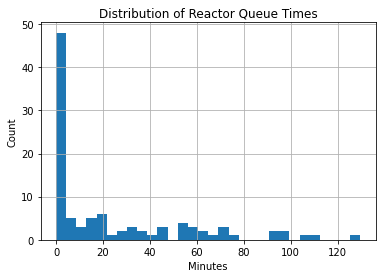

In [23]:
process_log(log)

<!--NAVIGATION-->
< [3.6 Simulating Queuing Systems](https://jckantor.github.io/CBE40455-2020/03.06-Queuing-Systems-and-Poisson-Processes.html) | [Contents](toc.html) |<p><a href="https://colab.research.google.com/github/jckantor/CBE40455-2020/blob/master/docs/03.07-Application-of-Queuing-Systems.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/CBE40455-2020/03.07-Application-of-Queuing-Systems.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>